In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from collections import deque
import pandas as pd
import math


import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.cuda.is_available()

True

In [2]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True],
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FALCO'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}

In [3]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

print(dataset.dataset['labels'].value_counts())
dataset.dataset.head()

/workspace/slp_jaspar/autoencoder_improvement/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


FOX               103069
FALCO              90719
MARTH              53728
CAPTAIN_FALCON     38006
SHEIK              27623
PEACH              17438
JIGGLYPUFF         16374
SAMUS               9524
ICE_CLIMBERS        6849
GANONDORF           6655
YOSHI               5725
LUIGI               5230
DR_MARIO            4202
PIKACHU             4096
LINK                2502
NESS                2306
DONKEY_KONG         2026
GAME_AND_WATCH      1967
MEWTWO              1775
MARIO               1713
YOUNG_LINK          1447
ROY                 1272
BOWSER               940
KIRBY                556
PICHU                230
Name: labels, dtype: int64


,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
0,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\727e819f-8cb3-4c3f-bf0a-ceefa9e41c...,5606,FALCO
1,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\76fe3db5-60de-46bb-8f0d-80d48822a8...,5754,FALCO
2,POKEMON_STADIUM,2,True,MARTH,HUMAN,HUMAN,mango\MARTH\7e6b417f-249d-4629-b6dc-2fe1d95d8f...,6213,MARTH
3,FOUNTAIN_OF_DREAMS,2,True,FOX,HUMAN,HUMAN,mango\FOX\32305eaf-71d8-46e5-a8a1-2c7c890a9baf...,7621,FOX
4,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\a5396c32-6f2c-4b88-8582-f8b875bb55...,7840,FALCO


In [4]:
labels_order =  dataset.number_of_segments_per_game(60,5000)
print(labels_order)
labels_order = labels_order['Label'].values

             Label   Count   Shift
0              FOX  103069  193497
1            FALCO   90717  168117
2            MARTH   53728  106569
3   CAPTAIN_FALCON   38006   70125
4            SHEIK   27623   59145
5            PEACH   17438   39398
6       JIGGLYPUFF   16374   35581
7            SAMUS    9524   23031
8     ICE_CLIMBERS    6849   15620
9        GANONDORF    6655   12805
10           YOSHI    5725   12226
11           LUIGI    5230   11464
12        DR_MARIO    4202    9062
13         PIKACHU    4096    8991
14            LINK    2502    5598
15            NESS    2306    5812
16     DONKEY_KONG    2026    4333
17  GAME_AND_WATCH    1967    3693
18          MEWTWO    1775    4511
19           MARIO    1713    3824
20      YOUNG_LINK    1447    3278
21             ROY    1272    2685
22          BOWSER     940    2196
23           KIRBY     556    1237
24           PICHU     230     491


In [5]:
train_df, test_df  = dataset.train_test_split_dataframes(test_ratio = .20, val = False)

                           player_inputs_np_sub_path  length  num_segments  \
0  public\FALCO\bee06d45-fca6-437f-969a-901efa166...   28801             1   
1  mango\FALCO\44e0962b-fdf7-4a16-acbe-61b5e5d609...   27200             1   
2  ranked\FALCO\2f51bb81-4304-4c6d-ac53-960aba87c...   26024             1   
3  ranked\FALCO\69cf9bb4-5f80-4e67-850d-ce0d7da1d...   25128             1   
4  ranked\FALCO\04257d15-f02f-4001-a191-37b97d2ed...   24323             1   

  labels  encoded_labels  
0  FALCO               4  
1  FALCO               4  
2  FALCO               4  
3  FALCO               4  
4  FALCO               4  


In [6]:
train_df, test_df = dataset.all_segments_train_test_split_dataframes(60, proportion_of_segments=1, test_ratio = .2, val = False)
porportion = .8
train_df = train_df.sample(frac=porportion, random_state = 42)
porportion = .05
test_df = test_df.sample(frac=porportion, random_state = 42)

In [7]:
print(train_df.shape)
print(test_df.shape)
print(test_df.shape[0] / (train_df.shape[0] + test_df.shape[0]))
train_df.head()

(42970042, 6)
(671279, 6)
0.015381729622712384


,player_inputs_np_sub_path,labels,encoded_labels,segment_start_index,segment_index,segment_length
18418491,ranked\FOX\555c5173-1750-4a33-b785-b38d0ff8aaa...,FOX,5,8142,138,60
25236203,ranked\FOX\cb87e4b2-2873-453d-b039-b0128a6cf86...,FOX,5,5487,93,60
25261750,ranked\FOX\804be79f-5a9f-47ca-bfda-ef5d2b8c06d...,FOX,5,472,8,60
23561687,ranked\FOX\8fee85f6-9cb4-4914-9324-87f8d8e9b5e...,FOX,5,8909,151,60
3974957,public\FALCO\8ea4f120-ad37-40a4-91bb-1aa235e12...,FALCO,4,4956,84,60


In [8]:
class TrainingDataset(Dataset):
    """
    Custom dataset for loading game segments from compressed numpy files.
    """
    def __init__(self, df, transform=None):
        self.file_paths = df['player_inputs_np_sub_path'].to_numpy()
        self.encoded_labels = df['encoded_labels'].to_numpy()
        self.segment_start_index = df['segment_start_index'].to_numpy()
        # self.segment_index = df['segment_index'].to_numpy()
        self.segment_length = df['segment_length'].to_numpy()
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.file_paths)

    def __getitem__(self, idx):
        """Loads and returns a sample from the dataset at the specified index."""
        with gzip.open('/workspace/melee_project_data/input_np/' + self.file_paths[idx].replace('\\','/'), 'rb') as f:
            segment = np.load(f)
        
        # Start and end of the segment
        segment_start = self.segment_start_index[idx]
        segment_end = self.segment_start_index[idx] + self.segment_length[idx]
        
        segment = segment[:,int(segment_start):int(segment_end)]
        
        # separate into positive and negative values
        # if self.transform:
        #     transformed = np.zeros((13,60))
        #     transformed[0,:] = (np.abs(segment[0]) - .2875) * 1.40350877193 * (segment[0] > 0)
        #     transformed[1,:] = (np.abs(segment[0]) - .2875) * 1.40350877193 * (segment[0] < 0)
        #     transformed[2,:] = (np.abs(segment[1]) - .2875) * 1.40350877193 * (segment[1] > 0)
        #     transformed[3,:] = (np.abs(segment[1]) - .2875) * 1.40350877193 * (segment[1] < 0)
        #     transformed[4,:] = (np.abs(segment[2]) - .2875) * 1.40350877193 * (segment[2] > 0)
        #     transformed[5,:] = (np.abs(segment[2]) - .2875) * 1.40350877193 * (segment[2] < 0)
        #     transformed[6,:] = (np.abs(segment[3]) - .2875) * 1.40350877193 * (segment[3] > 0)
        #     transformed[7,:] = (np.abs(segment[3]) - .2875) * 1.40350877193 * (segment[3] < 0)
        #     transformed[8:,:] = segment[4:]
        #     segment = transformed
        
        # if self.transform:
        #     # Shift inputs: adjusting so that positives are reduced and negatives are increased
        #     segment[0:4, :] -= .2875 * (segment[0:4, :] > 0)
        #     segment[0:4, :] += .2875 * (segment[0:4, :] < 0)

        #     # Scale inputs to be between -.5 and .5
        #     segment[0:4, :] *= 1.40350877193 / 2
        #     segment[0:4, :] += .5
        
        if self.transform:
            transformed = np.zeros((9,60))
            
            # First 4 rows of transformed are the analog inputs transformed to have range [0,1]
            # Shift inputs: adjusting so that positives are reduced and negatives are increased
            analog_transformed = np.copy(segment[0:4])
            analog_transformed[analog_transformed > 0] -= 0.2875 + 0.0125
            analog_transformed[analog_transformed < 0] += 0.2875 - 0.0125
            # Scale inputs to be between -.5 and .5
            analog_transformed *= .5 / .725
            # Add .5 to so final inputs are between 0 and 1
            analog_transformed += .5
            
            transformed[0:4] = analog_transformed
            # Next four rows are 1 if the corresponding analog input is 0
            # transformed[4:8] += (segment[:4] == 0)
            
            # Transform the Trigger so that it is 0 or 1
            transformed[-5] += (segment[-5] > .5)
            
            # Remaining rows are button inputs
            transformed[-4:] += segment[-4:]
            
            
        
        # Convert to PyTorch tensors
        segment_tensor = torch.from_numpy(transformed).float()
        # label_tensor = torch.tensor(self.encoded_labels[idx], dtype=torch.long)
        return segment_tensor#, label_tensor
    
def prepare_data_loaders(train_df, test_df, batch_size, num_workers):
    # Initialize datasets
    train_dataset = TrainingDataset(train_df,True)
    # val_dataset = TrainingDataset(file_paths_val, labels_val)
    test_dataset = TrainingDataset(test_df,True)

    # Initialize data loaders
    loaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True,persistent_workers=True),
        'test': DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True),
        # 'val': DataLoader(val_dataset, batch_size=2**9, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True)
    }
    return loaders



# ''' Get a batch of data to see the size if we want that information. ''' 
# data_loader_iterator = iter(loaders['train'])
# first_batch = next(data_loader_iterator)
# print(first_batch.shape)



In [9]:
def train_model_with_virtual_epochs(model, criterion, optimizer, loaders, device, num_epochs=1):
    scaler = GradScaler()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)
    best_loss = float('inf')
    best_model = None
    
    vepoch_total = 0
    vepoch_loss_sum = 0
    best_vepoch_loss = float('inf')

    early_stopping_patience = 0
    for epoch in range(num_epochs):
        model.train()
        train_loader_tqdm = tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        virtual_epoch_start_time = time.time()
     

        for batch_number, target_cpu in enumerate(train_loader_tqdm):
            target_gpu = target_cpu.to(device)
            optimizer.zero_grad()
            with autocast():
                output_gpu = model(target_gpu)
                loss = criterion(output_gpu, target_gpu) / (13 * 60 * target_cpu.size(0))

            scaler.scale(loss).backward()
            
            if any(torch.isnan(p.grad).any() for p in model.parameters() if p.grad is not None):
                print("Warning: NaN values in gradients!")
                # bad_targets = check_for_bad_targets(model, criterion, optimizer, target_gpu)
                # continue  # Consider handling or resolving NaN values before continuing

            scaler.unscale_(optimizer)  # Move this line here, ensuring it's only called when proceeding with optimizer step
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=100.0)
            scaler.step(optimizer)
            scaler.update()

            
            vepoch_total += target_cpu.size(0)
            vepoch_loss_sum += loss.item() * target_cpu.size(0)
            
            if time.time() - virtual_epoch_start_time > 60:
                vepoch_loss = vepoch_loss_sum / vepoch_total
                
                if best_vepoch_loss > vepoch_loss:
                    best_vepoch_loss = vepoch_loss
                else:
                    early_stopping_patience += 1
                    
                train_loader_tqdm.set_postfix(Best=f'{best_vepoch_loss * 10:.10f}', Vepoch=f'{vepoch_loss * 10:.10f}',patience=early_stopping_patience)
                scheduler.step(vepoch_loss)

                # if early_stopping_patience == 0:
                #     return
                    
                virtual_epoch_start_time = time.time()
                vepoch_total = 0
                vepoch_loss_sum = 0
    
    return best_model

def check_for_bad_targets(model, criterion, optimizer, targets_gpu):
    model.train()
    scaler = GradScaler()
    bad_targets = []
    
    try: 
        for i in range(targets_gpu.size(0)):  # Assuming the first dimension is the batch size
            single_target_gpu = targets_gpu[i].unsqueeze(0)  # Maintain batch dimension
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Forward and loss
            with autocast():
                output_gpu = model(single_target_gpu)
                loss = criterion(output_gpu, single_target_gpu) / (13 * 60)
            
            # Backward
            scaler.scale(loss).backward()
            
            # Check for NaNs in gradients
            if any(torch.isnan(p.grad).any() for p in model.parameters() if p.grad is not None):
                bad_targets.append(single_target_gpu.cpu().numpy())  # Move tensor to CPU and convert to numpy
        
        if bad_targets:
            print(f'There were {len(bad_targets)} bad target(s).')
            return bad_targets
        else:
            print('There were no bad targets.')
        return None   
     
    except:
        print('There was a problem evaluating the model on a single target.')
        return targets_gpu
            

def evaluate_model(model, criterion, loaders, loader, device):
    model.eval()
    eval_loss = 0
    total = 0
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit = 'batch')
        
        for batch_number, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            
            eval_loss += criterion(output_gpu, target_gpu) / ((32 * 16 * 4) * 13 * 60)
            
            
            total += target_gpu.shape[0] / (32 * 16 * 4)
            eval_loader_tqdm.set_postfix(loss=f'{eval_loss / (total):.10f}') 
            
    print(f'Evaluated Loss: {eval_loss / total:.10f}')
    
def evaluate_model(model, criterion, loaders, loader, device):
    model.eval()
    eval_loss = 0
    total = 0
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit = 'batch')
        
        for batch_number, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            
            eval_loss += criterion(output_gpu, target_gpu) 
            
            
            
            eval_loader_tqdm.set_postfix(loss=f'{eval_loss / (batch_number + 1):.10f}') 
            
    print(f'Evaluated Loss: {eval_loss / (batch_number + 1):.10f}')
    

In [10]:
from ResNet_Autoencoder_Model_Improved import ResNet_Autoencoder

channels = 9

# Build model
model = ResNet_Autoencoder(channels)
model.load_state_dict(torch.load('../../melee_project_data/improved_2_2_1s_autoencoder_weights.pt'))
model.to('cuda')
# # With the size of an input we can get a model summary.
summary(model, input_size=(channels, 60))

# Check that the output shape and target shape match
# training_example = torch.rand(9, 2 ** 12).to('cuda')
# print('Target shape:', training_example.shape)
# model.eval()
# output = model(training_example)
# print('Output shape:', output.shape)

## Optionally compile the model
# import torch_tensorrt
# model = torch.compile(model, mode = 'default')
# model = torch.compile(model,mode = 'max-autotune')
# model = torch.compile(model, backend="torch_tensorrt")
# model = torch.compile(model, backend="torch_tensorrt",mode = 'max-autotune')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 60]             640
       BatchNorm1d-2               [-1, 64, 60]             128
               ELU-3               [-1, 64, 60]               0
            Conv1d-4               [-1, 64, 60]          12,352
       BatchNorm1d-5               [-1, 64, 60]             128
               ELU-6               [-1, 64, 60]               0
            Conv1d-7              [-1, 256, 60]          16,640
       BatchNorm1d-8              [-1, 256, 60]             512
            Conv1d-9              [-1, 256, 60]           2,560
      BatchNorm1d-10              [-1, 256, 60]             512
              ELU-11              [-1, 256, 60]               0
Encoder_Bottleneck-12              [-1, 256, 60]               0
           Conv1d-13               [-1, 64, 60]          16,448
      BatchNorm1d-14               [-1

In [11]:
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

torch.autograd.set_detect_anomaly(False)
# Pepare data loaders
batch_size =  32 * 16
num_workers = 22
loaders = prepare_data_loaders(train_df, test_df, batch_size, num_workers)

    
# class CustomLoss(nn.Module):
#     def __init__(self):
#         super(CustomLoss, self).__init__()
#         self.bin_threshold = 2

#     def forward(self, pred, target):
#         # Splitting predictions and targets into sticks and buttons
#         pred_sticks = torch.tanh(pred[:4, :])  # First 4 rows for stick positions
#         pred_buttons = torch.sigmoid(pred[4:, :])  # Remaining rows for button states
#         target_sticks = target[:4, :]
#         target_buttons = target[4:, :]
        
#         # Calculate angles for j-stick (rows 0, 1) and c-stick (rows 2, 3)
#         target_angle_jstick = torch.atan2(target_sticks[1], target_sticks[0])
#         target_angle_cstick = torch.atan2(target_sticks[3], target_sticks[2])
#         epsilon = 1e-6
#         predicted_angle_jstick = torch.atan2(pred_sticks[1]*target_buttons[1] + epsilon, pred_sticks[0]*target_buttons[0] + epsilon)
#         predicted_angle_cstick = torch.atan2(pred_sticks[3]*target_buttons[3] + epsilon, pred_sticks[2]*target_buttons[2] + epsilon)

#         # Calculate radii for j-stick and c-stick
#         target_radius_jstick = torch.sqrt(target_sticks[0]**2 + target_sticks[1]**2)
#         target_radius_cstick = torch.sqrt(target_sticks[2]**2 + target_sticks[3]**2)
#         pred_radius_jstick = torch.sqrt(pred_sticks[0]**2 + pred_sticks[1]**2)
#         pred_radius_cstick = torch.sqrt(pred_sticks[2]**2 + pred_sticks[3]**2)
        
#         # Calculate smallest absolute angle difference
#         abs_smallest_angle_difference_jstick = torch.abs((target_angle_jstick - predicted_angle_jstick + np.pi) % (2 * np.pi) - np.pi)
#         abs_smallest_angle_difference_cstick = torch.abs((target_angle_cstick - predicted_angle_cstick + np.pi) % (2 * np.pi) - np.pi)
        
#         # Scale the angle difference
#         abs_smallest_angle_difference_jstick *= (0.5 / ((1 + 2 * self.bin_threshold) * 0.055))
#         abs_smallest_angle_difference_cstick *= (0.5 / ((1 + 2 * self.bin_threshold) * 0.055))
        
#         # Calculate absolute radius difference
#         abs_radius_difference_jstick = torch.abs(target_radius_jstick - pred_radius_jstick) * (0.5 / (1 + 2 * self.bin_threshold) * (1 / 114))
#         abs_radius_difference_cstick = torch.abs(target_radius_cstick - pred_radius_cstick) * (0.5 / (1 + 2 * self.bin_threshold) * (1 / 114))
        
#         # Calculate log loss for buttons
#         log_loss_buttons = -(target_buttons * torch.log(pred_buttons.clamp(min=1e-6, max=1-1e-6)) + (1 - target_buttons) * torch.log(1 - pred_buttons.clamp(min=1e-6, max=1-1e-6)))

#         loss_jstick = -torch.log(1 - abs_smallest_angle_difference_jstick.clamp(min=1e-6, max=1-1e-6)) - torch.log(1 - abs_radius_difference_jstick.clamp(min=1e-6, max=1-1e-6))
#         loss_cstick = -torch.log(1 - abs_smallest_angle_difference_cstick.clamp(min=1e-6, max=1-1e-6)) - torch.log(1 - abs_radius_difference_cstick.clamp(min=1e-6, max=1-1e-6))

#         return torch.sum(log_loss_buttons) + torch.sum(loss_jstick) +  torch.sum(loss_cstick)


class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bin_threshold = 2
        # Target sticks are roughly .00862 apart
        # self.bin_thresholds bins to the left and right means
        self.barely_close_enough = (.5 + self.bin_threshold) * .00862
        self.epsilon = .0000001
    
        
    def forward(self, pred, target):
        # Sigmoid has been applied, all values are in [0,1]
        abs_stick_diff = torch.abs(target[0:4] - pred[0:4])
        # Scale so that self.barely_close_enough becomes .5, i.e. multiply by 23.2018561485
        abs_stick_diff *= .5 / self.barely_close_enough
        log_abs_stick_diff = -torch.log(torch.clamp(1-abs_stick_diff, min=self.epsilon, max=1-self.epsilon))
        
        BCE_buttons = -  target[4:] * torch.log(torch.clamp(pred[4:], min=self.epsilon, max=1-self.epsilon)) - (1 - target[4:]) * torch.log(torch.clamp(1 - pred[4:], min=self.epsilon, max=1-self.epsilon))
        return torch.sum(log_abs_stick_diff) + torch.sum(BCE_buttons)


class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bin_threshold = 2
        # Self.bin_threshold bins to the left and right should account for the barely close enough threshold
        self.barely_close_enough = (.5 + self.bin_threshold) * 0.00862
        self.epsilon = 1e-7
        # Inverses of the weights for each feature, reshaped for proper broadcasting

    def forward(self, pred, target):
        # Sigmoid outputs for joystick values are between [0,1] and are first four in the data
        abs_stick_diff = torch.abs(target[:,0:4,0:60] - pred[:,0:4,0:60])
        # Rescale differences so that self.barely_close_enough corresponds to 0.5
        scale_factor = 0.5 / self.barely_close_enough
        abs_stick_diff *= scale_factor
        log_abs_stick_diff = torch.log(1 + abs_stick_diff)
        
        abs_button_difference = torch.abs(target[:,4:,0:60] - target[:,4:,0:60])
        # abs_button_difference[target[4:] == 1.] = (1 - pred[4:]) * self.weights
        log_abs_button_difference = torch.log(1 + abs_button_difference)
        
        return torch.sum(log_abs_stick_diff) + torch.sum(log_abs_button_difference)
    
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bin_threshold = 10
        # Self.bin_threshold bins to the left and right should account for the barely close enough threshold
        self.barely_close_enough = (.5 + self.bin_threshold) * 0.00862
        self.epsilon = 1e-7
        # Inverses of the weights for each feature, reshaped for proper broadcasting

    def forward(self, pred, target):
        # Sigmoid outputs for joystick values are between [0,1] and are first four in the data
        abs_stick_diff = torch.abs(target[:,0:4,0:60] - pred[:,0:4,0:60])
        # Rescale differences so that self.barely_close_enough corresponds to 0.5
        scale_factor = 0.5 / self.barely_close_enough
        abs_stick_diff *= scale_factor
        
        log_abs_stick_diff = torch.exp(abs_stick_diff)
        
        # abs_button_difference = torch.abs(target[:,4:,0:60] - target[:,4:,0:60])
        # abs_button_difference[target[4:] == 1.] = (1 - pred[4:]) * self.weights
        BCE_buttons = -  target[:,4:,0:60] * torch.log(pred[:,4:,0:60]) - (1 - target[:,4:,0:60]) * torch.log(1 - pred[:,4:,0:60])
        
        return torch.sum(log_abs_stick_diff) + torch.sum(BCE_buttons)
    
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.BCE = nn.BCEWithLogitsLoss(reduction='sum')  # Consider using weighted BCE if needed
        self.MSE = nn.MSELoss(reduction='sum')
        self.bin_threshold = 2
        # Self.bin_threshold bins to the left and right should account for the barely close enough threshold
        self.barely_close_enough = (.5 + self.bin_threshold) * 0.00862#
        self.scale_factor = - math.log(.5) / self.barely_close_enough ** 2
        
    def forward(self, pred, target):
        # Calculating losses
        mse_loss = self.MSE(torch.sigmoid(pred[:,0:4,0:60]), target[:,0:4,0:60]) 
        bce_loss = self.BCE(pred[:,4:,0:60], target[:,4:,0:60])
        
        # Total loss
        return mse_loss  + bce_loss / 100
    
# class CustomLoss(nn.Module):
#     def __init__(self):
#         super(CustomLoss, self).__init__()
#         self.bin_threshold = 2
#         # Define barely close enough threshold
#         self.barely_close_enough = (.5 + self.bin_threshold) * 0.00862
#         self.epsilon = 1e-7
#         # Inverses of the weights for each feature
#         self.weights = (torch.tensor([1, 1, 1, 1, 0.172214** -1, 0.008446** -1, 0.060667** -1, 0.045861** -1, 0.098047** -1]).reshape((1, -1, 1)) ).to('cuda')

#     def forward(self, pred, target):
#         # Assuming pred and target are in the shape [batch_size, num_features]
#         # Process joystick differences
#         abs_stick_diff = torch.abs(target[:, 0:4] - pred[:, 0:4])
#         scale_factor = 0.5 / self.barely_close_enough
#         abs_stick_diff *= scale_factor
#         log_abs_stick_diff = torch.log(1 + abs_stick_diff)

#         # Process button differences
#         button_diff = torch.abs(target[:, 4:] - pred[:, 4:])
#         log_abs_button_diff = torch.log(1 + button_diff)
#         # weights = (target[:,4:] > .5) * self.weights
#         return torch.sum(log_abs_stick_diff) + torch.sum(log_abs_button_diff)

criterion = CustomLoss()

optimizer = Adam(model.parameters(), lr=0.00001)
num_epochs = 1

# This seems to sometimes help
gc.collect()
torch.cuda.empty_cache()
# Train the model
# start_time = time.time()
# train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)
# train_model_with_virtual_epochs(model, criterion, optimizer, loaders, 'cuda', num_epochs)
# print(f'Batch Size: {batch_size}, Training time: {time.time() - start_time:.2f}')

# Again, this sometimes seems to help
# gc.collect()
# torch.cuda.empty_cache()

# Evaluate the trained model
# evaluate_model(model, criterion, loaders, 'test', 'cuda')

In [12]:
# optimizer = Adam(model.parameters(), lr=0.00001)
# num_epochs = 1

# # # This seems to sometimes help
# # gc.collect()
# # torch.cuda.empty_cache()
# # # Train the model
# # # start_time = time.time()
# # # train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)
# train_model_with_virtual_epochs(model, criterion, optimizer, loaders, 'cuda', num_epochs)

In [13]:
# torch.save(model.state_dict(), '../../melee_project_data/improved_2_2_1s_autoencoder_weights.pt')
# torch.save(model, '../../melee_project_data/improved_2_2_1s_autoencoder_model.pt')

In [14]:
def predict(model, loaders, loader, device):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit='batch')
        
        for _, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            # output_gpu = torch.sigmoid(output_gpu)
            
            predictions.append(torch.sigmoid(output_gpu).cpu().numpy())
            targets.append(target_cpu.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    

    return predictions, targets

In [15]:
gc.collect()
torch.cuda.empty_cache()

pred, target = predict(model, loaders, 'test','cuda')

100%|██████████| 1312/1312 [00:36<00:00, 36.20batch/s]


In [16]:
def predicted_button_analysis(pred, target):
    buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
    
    # Create dictionary to hold the data
    data = {}
    
    # Process for first frame and last frame for both target and pred
    for index, button in enumerate(buttons):
        data[f'{button}_first_frame_target'] = (target[:, -5+index, 0] > .5).astype(int)
        data[f'{button}_first_frame_pred'] = (pred[:, -5+index, 0] > .5).astype(int)
        data[f'{button}_last_frame_target'] = (target[:, -5+index, -1] > .5).astype(int)
        data[f'{button}_last_frame_pred'] = (pred[:, -5+index, -1] > .5).astype(int)
        
        # Ensure that the dimensions match for prepend operation
        prepend_target = np.expand_dims(target[:, -5+index, 0], axis=1)
        prepend_pred = np.expand_dims(pred[:, -5+index, 0], axis=1)

        transitions_target = np.diff(target[:, -5+index, :], axis=1, prepend=prepend_target)
        transitions_pred = np.diff(pred[:, -5+index, :], axis=1, prepend=prepend_pred)
        
        count_0_to_1_target = np.sum(transitions_target > .5, axis=1)
        count_0_to_1_target += target[:,-5+index,0] > .5
        count_0_to_1_pred = np.sum(transitions_pred > .5, axis=1)
        count_0_to_1_pred += pred[:,-5+index,0] > .5
        
        data[f'{button}_num_presses_target'] = count_0_to_1_target
        data[f'{button}_num_presses_pred'] = count_0_to_1_pred
        
    # Create DataFrame from the dictionary
    df = pd.DataFrame(data)
    
    return df

# Example usage:
# Assuming 'pred' and 'target' are defined and appropriate for this function
df = predicted_button_analysis(pred, target)
print(df.describe())
# df.head()

       TRIGGER_LOGICAL_first_frame_target  TRIGGER_LOGICAL_first_frame_pred  \
count                       671279.000000                     671279.000000   
mean                             0.166922                          0.164833   
std                              0.372906                          0.371030   
min                              0.000000                          0.000000   
25%                              0.000000                          0.000000   
50%                              0.000000                          0.000000   
75%                              0.000000                          0.000000   
max                              1.000000                          1.000000   

       TRIGGER_LOGICAL_last_frame_target  TRIGGER_LOGICAL_last_frame_pred  \
count                      671279.000000                    671279.000000   
mean                            0.167255                         0.161776   
std                             0.373204                 

In [17]:
buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
# buttons = ['X_or_Y']


summary_df = pd.DataFrame(np.arange(7,dtype=np.int16),columns=['Target Pressed'])
# print(summary_df)


for index, button in enumerate(buttons):
    print('-----', button, '-----')
    example_data = []
    accuracy_data = []
    under_predicted_data = []
    for i in range(7):
        print()
        print(f'Pressed {i} times')
        df_button_is_pressed = df[df[f'{button}_num_presses_target'] == i]
        columns = [
                    f'{button}_first_frame_target',
                    f'{button}_first_frame_pred',
                    f'{button}_last_frame_target',
                    f'{button}_last_frame_pred',
                    f'{button}_num_presses_target',
                    f'{button}_num_presses_pred']    
        df_button_is_pressed = df_button_is_pressed[columns]
        
        # print(f'Target was pressed {i} time(s): < 0 means under predicting')
        df_button_is_pressed['Off by'] = df_button_is_pressed[f'{button}_num_presses_pred'] - df_button_is_pressed[f'{button}_num_presses_target']
        counts = df_button_is_pressed['Off by'].value_counts().sort_index().to_frame(name='Count')

        # Calculating accuracy
        total_presses = counts['Count'].sum()
        correct_predictions = counts.loc[0, 'Count'] if 0 in counts.index else 0
        accuracy = correct_predictions / total_presses if total_presses > 0 else 0
        print(counts)
        print('Accuracy:', "{:.4f}".format(accuracy))
        accuracy_data += [accuracy]
        
                # Calculating under-prediction rate among non-zero predictions
        under_predicted = counts[counts.index < 0]['Count'].sum() if any(counts.index < 0) else 0
        non_zero_predictions = total_presses - (counts.loc[0, 'Count'] if 0 in counts.index else 0)
        under_prediction_rate = under_predicted / non_zero_predictions if non_zero_predictions > 0 else 0
        print(f'Under-prediction rate: {under_prediction_rate:.4f}')
        under_predicted_data += [under_prediction_rate]
        
        example_data += [df_button_is_pressed.shape[0] / df.shape[0]]
        
    print()
        
    summary_df[f'{button} Examples'] = example_data
    summary_df[f'{button} Correct'] = accuracy_data
    summary_df[f'{button} Under'] = under_predicted_data




----- TRIGGER_LOGICAL -----

Pressed 0 times
    Count
0  281812
1      73
Accuracy: 0.9997
Under-prediction rate: 0.0000

Pressed 1 times
     Count
-1    2418
 0  278095
 1    1923
 2      26
 3       1
Accuracy: 0.9845
Under-prediction rate: 0.5536

Pressed 2 times
    Count
-2    197
-1   3433
 0  90813
 1    656
 2      6
Accuracy: 0.9549
Under-prediction rate: 0.8458

Pressed 3 times
    Count
-3     52
-2    209
-1   1185
 0   9332
 1     56
 2      1
Accuracy: 0.8613
Under-prediction rate: 0.9621

Pressed 4 times
    Count
-4     22
-3     46
-2     73
-1    178
 0    512
 1     10
Accuracy: 0.6088
Under-prediction rate: 0.9696

Pressed 5 times
    Count
-5     13
-4     18
-3     11
-2     18
-1     21
 0     26
 1      3
Accuracy: 0.2364
Under-prediction rate: 0.9643

Pressed 6 times
    Count
-6      7
-5      9
-4      3
-2      4
-1      3
 0      3
Accuracy: 0.1034
Under-prediction rate: 1.0000

----- Z -----

Pressed 0 times
    Count
0  624242
1      35
Accuracy: 0.9999

In [18]:
print('Table shows:')
print('- The percentage of test examples that were actually pressed n times.')
print('- Accuracy of the prediction given the button was pressed n times.')
print('- Under prediction rate of an incorrect prediction given the button was pressed n times.')           
summary_df

Table shows:
- The percentage of test examples that were actually pressed n times.
- Accuracy of the prediction given the button was pressed n times.
- Under prediction rate of an incorrect prediction given the button was pressed n times.


,Target Pressed,TRIGGER_LOGICAL Examples,TRIGGER_LOGICAL Correct,TRIGGER_LOGICAL Under,Z Examples,Z Correct,Z Under,A Examples,A Correct,A Under,B Examples,B Correct,B Under,X_or_Y Examples,X_or_Y Correct,X_or_Y Under
0,0,0.419922,0.999741,0.000000,0.929981,0.999944,0.000000,0.664876,0.999816,0.000000,0.774156,0.999831,0.000000,0.383006,0.990638,0.000000
1,1,0.420783,0.984536,0.553571,0.058774,0.932630,0.987585,0.218245,0.901668,0.544426,0.166765,0.933396,0.736186,0.396677,0.862476,0.425669
2,2,0.141677,0.954871,0.845760,0.007599,0.836699,0.991597,0.074672,0.872382,0.683602,0.039155,0.889476,0.819966,0.175064,0.801271,0.603879
3,3,0.016141,0.861283,0.962076,0.002199,0.753388,0.997253,0.026017,0.840309,0.797060,0.011934,0.832356,0.901713,0.033262,0.753046,0.688792
4,4,0.001253,0.608799,0.969605,0.000901,0.727273,0.993939,0.010112,0.806276,0.881369,0.004555,0.809026,0.933219,0.007142,0.721527,0.679401
5,5,0.000164,0.236364,0.964286,0.000285,0.670157,1.000000,0.003554,0.743923,0.955810,0.001810,0.757202,0.959322,0.002620,0.709494,0.690802
6,6,0.000043,0.103448,1.000000,0.000145,0.639175,1.000000,0.001484,0.699799,0.983278,0.000871,0.716239,0.987952,0.001351,0.737596,0.802521


In [19]:
summary_df[['Target Pressed', 'TRIGGER_LOGICAL Correct', 'Z Correct', 'A Correct', 'B Correct', 'X_or_Y Correct']]

,Target Pressed,TRIGGER_LOGICAL Correct,Z Correct,A Correct,B Correct,X_or_Y Correct
0,0,0.999741,0.999944,0.999816,0.999831,0.990638
1,1,0.984536,0.932630,0.901668,0.933396,0.862476
2,2,0.954871,0.836699,0.872382,0.889476,0.801271
3,3,0.861283,0.753388,0.840309,0.832356,0.753046
4,4,0.608799,0.727273,0.806276,0.809026,0.721527
5,5,0.236364,0.670157,0.743923,0.757202,0.709494
6,6,0.103448,0.639175,0.699799,0.716239,0.737596


Given the target button was pressed once and the prediction was pressed once. How big was the difference in length of the button press. TO DO: further restrict to the prediction being pressed for the same number of frames and seeing if it was pressed at the exact same time.

TRIGGER_LOGICAL
[[   -13      1]
 [   -10      2]
 [    -8      2]
 [    -7      2]
 [    -6      8]
 [    -5     20]
 [    -4     56]
 [    -3    270]
 [    -2   6843]
 [    -1  80987]
 [     0 189266]
 [     1    530]
 [     2     50]
 [     3     16]
 [     4     11]
 [     5      2]
 [     6      1]
 [     8      1]
 [     9      2]
 [    10      3]
 [    11      2]
 [    13      1]
 [    14      1]
 [    15      1]
 [    17      1]
 [    18      2]
 [    23      1]
 [    27      3]
 [    28      1]
 [    29      1]
 [    31      1]
 [    35      1]
 [    39      1]
 [    43      2]
 [    44      1]
 [    46      1]
 [    57      1]]


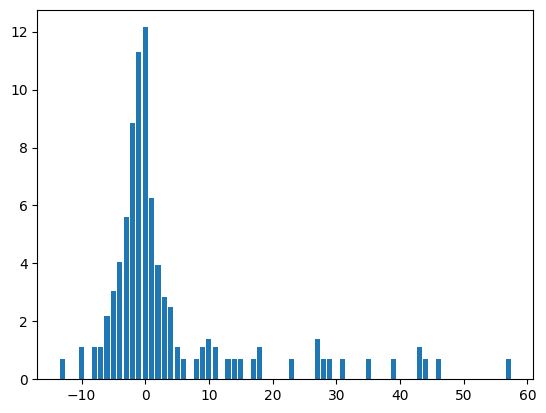

Z
[[   -7     1]
 [   -5     3]
 [   -4    19]
 [   -3   103]
 [   -2  3604]
 [   -1 17165]
 [    0 15835]
 [    1    55]
 [    2     4]
 [    3     3]
 [    4     1]
 [    7     1]
 [   11     1]
 [   22     1]]


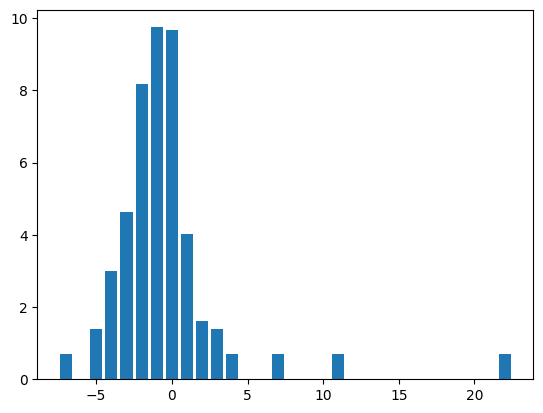

A
[[  -10     2]
 [   -9     1]
 [   -7     1]
 [   -6    10]
 [   -5    48]
 [   -4   128]
 [   -3   950]
 [   -2 32516]
 [   -1 59361]
 [    0 38297]
 [    1   633]
 [    2   118]
 [    3    23]
 [    4     5]
 [    5     1]
 [    8     1]
 [   25     1]
 [   48     1]]


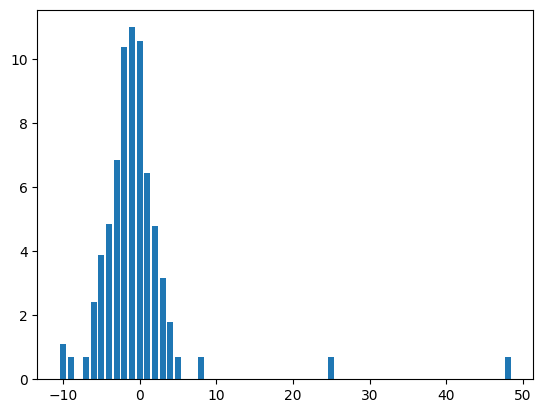

B
[[  -27     1]
 [  -16     1]
 [  -11     1]
 [  -10     1]
 [   -9     4]
 [   -8     5]
 [   -7     9]
 [   -6    23]
 [   -5    39]
 [   -4   109]
 [   -3   525]
 [   -2 12644]
 [   -1 49012]
 [    0 41966]
 [    1   130]
 [    2    11]
 [    3     2]
 [    5     2]
 [    6     2]
 [   10     3]]


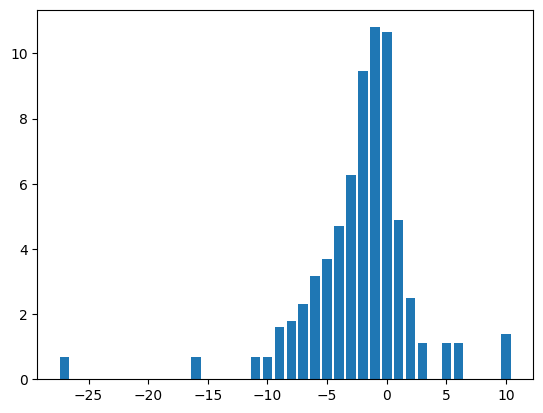

X_or_Y
[[  -54     1]
 [  -31     1]
 [  -30     2]
 [  -26     2]
 [  -24     1]
 [  -23     1]
 [  -22     1]
 [  -20     2]
 [  -19     2]
 [  -18     2]
 [  -17     8]
 [  -16     7]
 [  -15    11]
 [  -14     3]
 [  -13    16]
 [  -12    15]
 [  -11    26]
 [  -10    39]
 [   -9    59]
 [   -8    84]
 [   -7   129]
 [   -6   220]
 [   -5   373]
 [   -4   734]
 [   -3  2172]
 [   -2 65466]
 [   -1 95079]
 [    0 63310]
 [    1  1328]
 [    2   118]
 [    3    51]
 [    4    22]
 [    5    15]
 [    6    16]
 [    7    14]
 [    8    17]
 [    9     9]
 [   10     7]
 [   11     6]
 [   12    13]
 [   13    11]
 [   14     8]
 [   15    14]
 [   16     6]
 [   17    10]
 [   18    10]
 [   19    13]
 [   20     9]
 [   21     7]
 [   22     8]
 [   23    15]
 [   24     7]
 [   25    10]
 [   26    13]
 [   27     6]
 [   28     5]
 [   29    14]
 [   30     6]
 [   31    10]
 [   32    10]
 [   33    10]
 [   34     6]
 [   35     3]
 [   36     5]
 [   37     2]
 [   38     2]
 [ 

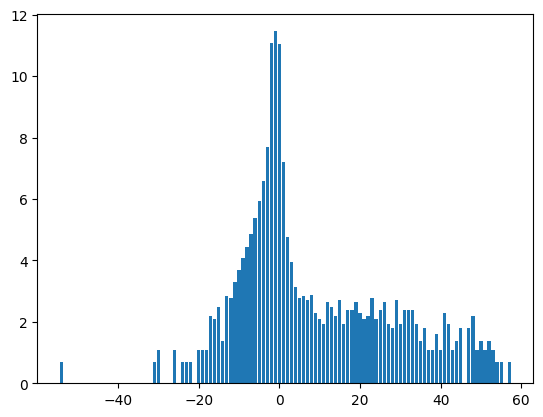

In [20]:
buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
results = []

for index, button in enumerate(buttons):
    button_is_pressed_once = (df[f'{button}_num_presses_target'] == 1) & (df[f'{button}_num_presses_pred'] == 1)
    
    
    # Filtering rows where the button was pressed exactly once in both target and prediction
    target_button_is_pressed_once = target[button_is_pressed_once, -5+index, :]
    pred_button_is_pressed_once = pred[button_is_pressed_once, -5+index, :]
    
    # Calculating indices for the first and last button press in the target and prediction for each example
    index_of_first_1_target = np.argmax(target_button_is_pressed_once > 0.5, axis=1)
    index_of_first_1_pred = np.argmax(pred_button_is_pressed_once > 0.5, axis=1)
    index_of_last_1_target = (target_button_is_pressed_once.shape[1] - np.argmax(target_button_is_pressed_once[:, ::-1] > 0.5, axis=1))
    index_of_last_1_pred = (pred_button_is_pressed_once.shape[1] - np.argmax(pred_button_is_pressed_once[:, ::-1] > 0.5, axis=1))

    length_of_target_press = index_of_last_1_target - index_of_first_1_target
    length_of_pred_press = index_of_last_1_pred - index_of_first_1_pred
    
    unique, count = np.unique(length_of_pred_press - length_of_target_press, return_counts=True)
    print(button)
    print(np.array([unique,count]).T)

    plt.bar(unique,np.log(count+1))
    plt.show()
    


Investigate the differece in the angle of the joystick and c-stick.h

In [21]:
# Transform the target back to the the standard stick input. 
# 9 channels
target_no_transform = target[:, :4, :] - .5
target_no_transform[0:4, :] /= .5 / .725
target_no_transform[target_no_transform[:, 0:4, :] < 0] -= .2875 + 0.0125
target_no_transform[target_no_transform[:, 0:4, :] < 0] += .2875 - 0.0125
# target_no_transform *= target[:,4:8,:]
 
predicted_no_transform = pred[:, :4, :] - .5
predicted_no_transform[0:4, :] /= .5 / .725
predicted_no_transform[predicted_no_transform[:, 0:4, :] < 0] -= .2875 + 0.0125
predicted_no_transform[predicted_no_transform[:, 0:4, :] < 0] += .2875 - 0.0125

target_angle_JSTICK = np.arctan2(target_no_transform[:,0,:], target_no_transform[:,1,:]) * 180 / np.pi
predicted_angle_JSTICK = np.arctan2(predicted_no_transform[:,0,:], predicted_no_transform[:,1,:]) * 180 / np.pi

target_radius_JSTICK = np.sqrt(target_no_transform[:,0,:] ** 2 + target_no_transform[:,1,:] ** 2)
pred_radius_JSTICK = np.sqrt(predicted_no_transform[:,0,:] ** 2 + predicted_no_transform[:,1,:] ** 2)

print(target_no_transform[:,0,:])
# # print(target_no_transform[:,1,:])
print()

print(predicted_no_transform[:,0,:])
# # print(predicted_no_transform[:,1,:])
# print()

# print(target_angle_JSTICK)
# print(predicted_angle_JSTICK)
# print()

# print(target_radius_JSTICK)
# print(pred_radius_JSTICK)

[[-0.475      -0.49999997 -0.49999997 ...  0.          0.
   0.        ]
 [ 0.6750001   0.6750001   0.68749994 ...  0.          0.
   0.        ]
 [-0.7375001  -0.7375001  -0.7375001  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.36206895  0.37068963
   0.37931037]
 [-0.23189655 -0.1887931  -0.14568964 ...  0.18965518  0.18103445
   0.18965518]
 [ 0.         -0.09396553 -0.3181034  ...  0.3362069   0.48275864
   0.4741379 ]]

[[-4.9541751e-01 -4.8286054e-01 -4.9964473e-01 ...  2.2954941e-03
   1.4329552e-04 -2.5307298e-02]
 [ 6.8019539e-01  6.7709017e-01  6.6341448e-01 ...  5.9764087e-04
   6.6730083e-04 -2.9480338e-02]
 [-7.1725357e-01 -7.2240555e-01 -7.2370887e-01 ...  5.6940527e-03
   2.5317848e-03  1.2467920e-03]
 ...
 [ 1.0330677e-03  4.2892098e-03  1.3181567e-03 ...  3.6962581e-01
   3.7494236e-01  3.7684637e-01]
 [-2.4371031e-01 -2.0040470e-01 -1.3515472e-01 ...  1.8339938e-01
   1.7821163e-01  1.6023993e-01]
 [ 4.8257113e-03 -1.2271935e-01

Trasform the stick predictions back to the original inputs.

In [22]:
target_sticks_no_transform = target[:, :4] - .5
target_sticks_no_transform /= .5 / .725
target_sticks_no_transform[target_sticks_no_transform < 0] -= .2875 + 0.0125
target_sticks_no_transform[target_sticks_no_transform < 0] += .2875 - 0.0125
 
predicted_sticks_no_transform = pred[:, :4] - .5
predicted_sticks_no_transform /= .5 / .725
predicted_sticks_no_transform[predicted_sticks_no_transform < 0] -= .2875 + 0.0125
predicted_sticks_no_transform[predicted_sticks_no_transform < 0] += .2875 - 0.0125

# Multiply by 0 where the model predicted the stick input to be 0
# predicted_sticks_no_transform *= (pred[:,4:8] < .5)
predicted_sticks_no_transform *= (target[:,4:8] < .5)
# predicted_sticks_no_transform = np.where(predicted_sticks_no_transform == 0.0, 0.0, predicted_sticks_no_transform)

target_angle_JSTICK = np.arctan2(target_sticks_no_transform[:,[1,3]], target_sticks_no_transform[:,[0,2]]) * 180 / np.pi
predicted_angle_JSTICK = np.arctan2(predicted_sticks_no_transform[:,[1,3]], predicted_sticks_no_transform[:,[0,2]]) * 180 / np.pi

angle_difference_no_transform = (predicted_angle_JSTICK - target_angle_JSTICK) 
smallest_angle_difference_no_transform = np.abs((angle_difference_no_transform + 180) % 360 - 180)

target_radius_squared_no_transform = target_sticks_no_transform[:,[0,2]] ** 2 + target_sticks_no_transform[:,[1,3]] ** 2
pred_radius_squared_no_transform = predicted_sticks_no_transform[:,[0,2]] ** 2 + predicted_sticks_no_transform[:,[1,3]] ** 2

radius_difference_no_trasform = np.abs(target_radius_squared_no_transform - pred_radius_squared_no_transform) ** (1/2)

print('JSTICK average angle difference', np.average(smallest_angle_difference_no_transform[:,0]))
print('CSTICK average angle difference', np.average(smallest_angle_difference_no_transform[:,1]))

print('JSTICK average radius difference', np.average(radius_difference_no_trasform[:,0]))
print('CSTICK average radius difference', np.average(radius_difference_no_trasform[:,1]))

JSTICK average angle difference 37.783302
CSTICK average angle difference 140.50998
JSTICK average radius difference 0.14424282
CSTICK average radius difference 0.0417362


In [23]:
target_sticks_no_transform = np.round(target[:,0:4] / 0.008620689655172415 ).astype(np.int32) * 0.008620689655172415 - .5
predicted_sticks_no_transform = np.round(pred[:,0:4] / 0.008620689655172415).astype(np.int32) * 0.008620689655172415 - .5

# target_sticks_no_transform = target[:, :4] - .5
target_sticks_no_transform /= .5 / .725
target_sticks_no_transform[target_sticks_no_transform < 0] -= .2875 + 0.0125
target_sticks_no_transform[target_sticks_no_transform < 0] += .2875 - 0.0125
 
# predicted_sticks_no_transform = pred[:, :4] - .5
predicted_sticks_no_transform /= .5 / .725
predicted_sticks_no_transform[predicted_sticks_no_transform < 0] -= .2875 + 0.0125
predicted_sticks_no_transform[predicted_sticks_no_transform < 0] += .2875 - 0.0125

# Multiply by 0 where the model predicted the stick input to be 0
# predicted_sticks_no_transform *= (pred[:,4:8] < .5)
# predicted_sticks_no_transform *= (target[:,4:8,:] < .5)
# predicted_sticks_no_transform = np.where(predicted_sticks_no_transform == 0.0, 0.0, predicted_sticks_no_transform)

target_angle_JSTICK = np.arctan2(target_sticks_no_transform[:,[1,3]], target_sticks_no_transform[:,[0,2]]) * 180 / np.pi
predicted_angle_JSTICK = np.arctan2(predicted_sticks_no_transform[:,[1,3]], predicted_sticks_no_transform[:,[0,2]]) * 180 / np.pi

angle_difference_no_transform = (predicted_angle_JSTICK - target_angle_JSTICK) 
smallest_angle_difference_no_transform = np.abs((angle_difference_no_transform + 180) % 360 - 180)

target_radius_squared_no_transform = target_sticks_no_transform[:,[0,2]] ** 2 + target_sticks_no_transform[:,[1,3]] ** 2
pred_radius_squared_no_transform = predicted_sticks_no_transform[:,[0,2]] ** 2 + predicted_sticks_no_transform[:,[1,3]] ** 2

radius_difference_no_trasform = np.abs(target_radius_squared_no_transform - pred_radius_squared_no_transform) ** (1/2)

print('JSTICK average angle difference', np.average(smallest_angle_difference_no_transform[:,0]))
print('CSTICK average angle difference', np.average(smallest_angle_difference_no_transform[:,1]))

print('JSTICK average radius difference', np.average(radius_difference_no_trasform[:,0]))
print('CSTICK average radius difference', np.average(radius_difference_no_trasform[:,1]))




JSTICK average angle difference 5.070507038240152
CSTICK average angle difference 3.1221916977154303
JSTICK average radius difference 0.08707491722127442
CSTICK average radius difference 0.013815596514231334


In [24]:
pred_binary_0 = (target[:,:4] == 0)
pred_stick_0 = predicted_sticks_no_transform == 0.


# print('Binary and continuous both predicted 0 JSTICK_X:', np.sum((target[:,4,:] > .5)) / (pred_binary_0.shape[0] * 60) * 100)
# print('Binary and continuous both predicted 0 JSTICK_Y:', np.sum((target[:,5,:] > .5)) / (pred_binary_0.shape[0] * 60) * 100)
# print('Binary and continuous both predicted 0 CSTICK_X:', np.sum((target[:,6,:] > .5)) / (pred_binary_0.shape[0] * 60) * 100)
# print('Binary and continuous both predicted 0 CSTICK_Y:', np.sum((target[:,7,:] > .5)) / (pred_binary_0.shape[0] * 60) * 100)

# print()

print('Binary and continuous both predicted 0 JSTICK_X:', np.sum(pred_binary_0[:,0] == pred_stick_0[:,0]) / (pred_binary_0.shape[0] * 60) * 100)
print('Binary and continuous both predicted 0 JSTICK_Y:', np.sum(pred_binary_0[:,1] == pred_stick_0[:,1]) / (pred_binary_0.shape[0] * 60) * 100)
print('Binary and continuous both predicted 0 CSTICK_X:', np.sum(pred_binary_0[:,2] == pred_stick_0[:,2]) / (pred_binary_0.shape[0] * 60) * 100)
print('Binary and continuous both predicted 0 CSTICK_Y:', np.sum(pred_binary_0[:,3] == pred_stick_0[:,3]) / (pred_binary_0.shape[0] * 60) * 100)

Binary and continuous both predicted 0 JSTICK_X: 95.67125343312294
Binary and continuous both predicted 0 JSTICK_Y: 97.96273978479887
Binary and continuous both predicted 0 CSTICK_X: 99.72256692075872
Binary and continuous both predicted 0 CSTICK_Y: 99.66337643016789


In [25]:
import pandas as pd
import numpy as np

buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']

first_and_last_df = pd.DataFrame(buttons, columns=['Button'])
for index, button in enumerate(buttons):
    first_frame_0 = (df[f'{button}_first_frame_target'] == 0)
    last_frame_0 = (df[f'{button}_last_frame_target'] == 0)
    
    first_and_last_df.loc[index, 'Ratio target[0]==0'] = first_frame_0.mean()
    first_and_last_df.loc[index, 'Acc target[0]==0'] = 1 - df.loc[first_frame_0, f'{button}_first_frame_pred'].mean()
    first_and_last_df.loc[index, 'Acc target[0]==1'] = df.loc[~first_frame_0, f'{button}_first_frame_pred'].mean()
    
    first_and_last_df.loc[index, 'Ratio target[-1]==0'] = last_frame_0.mean()
    first_and_last_df.loc[index, 'Acc target[-1]==0'] = 1-df.loc[last_frame_0, f'{button}_last_frame_pred'].mean()
    first_and_last_df.loc[index, 'Acc target[-1]==1'] = df.loc[~last_frame_0, f'{button}_last_frame_pred'].mean()
    
print('Table shows:')
print('- Percentage of test examples where the button was not pressed on the first or last frame')
print('- Given the button was pressed or not on the first or last frame, what was the accuracy of the prediction.')

first_and_last_df


Table shows:
- Percentage of test examples where the button was not pressed on the first or last frame
- Given the button was pressed or not on the first or last frame, what was the accuracy of the prediction.


,Button,Ratio target[0]==0,Acc target[0]==0,Acc target[0]==1,Ratio target[-1]==0,Acc target[-1]==0,Acc target[-1]==1
0,TRIGGER_LOGICAL,0.833078,0.999013,0.982562,0.832745,0.997796,0.956268
1,Z,0.990826,0.999968,0.881617,0.990782,0.999928,0.844861
2,A,0.937960,0.999689,0.917519,0.937503,0.999465,0.807189
3,B,0.955071,0.999819,0.928581,0.955196,0.999791,0.820654
4,X_or_Y,0.901242,0.997307,0.836592,0.901464,0.998453,0.530365


Check how accurately the model predicted model predicted each analog input being zero.

In [26]:
# correct_zero_stick = (pred[:,4:8] == 1) and (target[:,4:8] == 1)
# print('Accuracy of JSTICK_X = 0:', np.sum(correct_zero_stick[:,0]) / np.sum(target[:,4]) * 100)
# print('Accuracy of JSTICK_Y = 0:', np.sum(correct_zero_stick[:,1]) / np.sum(target[:,5]) * 100)
# print('Accuracy of CSTICK_X = 0:', np.sum(correct_zero_stick[:,2]) / np.sum(target[:,6]) * 100)
# print('Accuracy of JSTICK_Y = 0:', np.sum(correct_zero_stick[:,3]) / np.sum(target[:,7]) * 100)



In [27]:
print(np.max(pred[:,0:4]))
print(np.max(target[:,0:4]))

0.99448276
0.98275864


We make try to figure out how close the predicted stick vales were to the actual values. The possible stick values are discreet and we round the prediction to the nearest possibility.

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115]
Good enough accuracy of JSICK_X 0.6393690253977854
Accuracy 

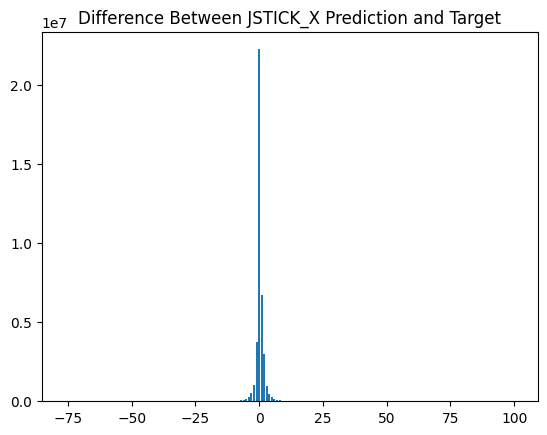

Good enough accuracy of JSTICK_Y 0.07552498042294387
Accuracy of JSTICK_Y 0.020341765495419935


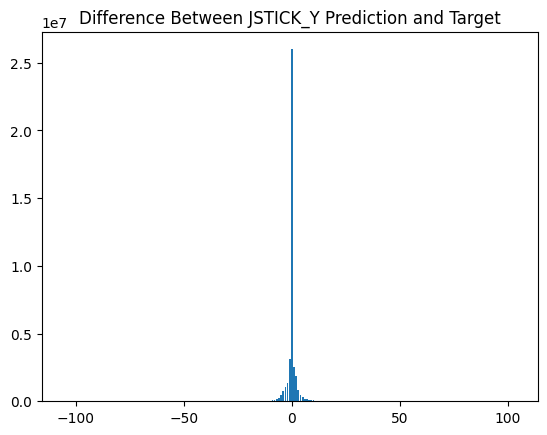

Good enough accuracy of CSTICK_X 0.35394622305578854
Accuracy of CSTICK_X 0.09474202728423402


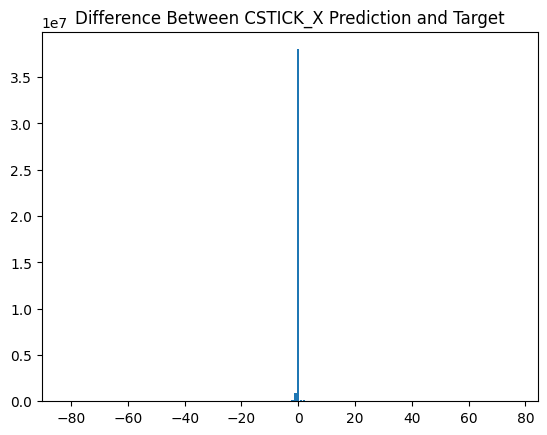

Good enough accuracy of CSTICK_Y 0.4256526223323933
Accuracy of CSTICK_Y 0.11337312801383628


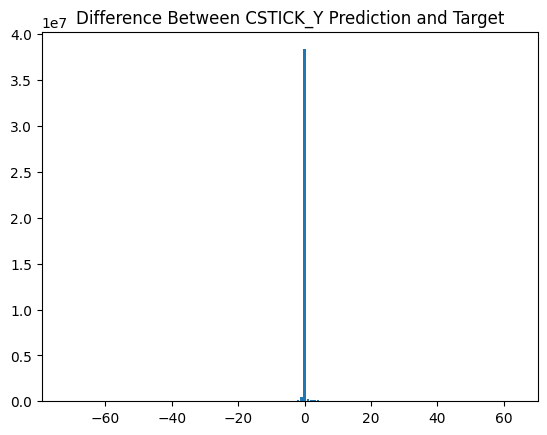

In [28]:
integer_stick_targets = np.round(target[:,0:4] / 0.008620689655172415 ).astype(np.int32)
integer_stick_pred = np.round(pred[:,0:4] / 0.008620689655172415).astype(np.int32)

print(np.unique(integer_stick_targets))
print(np.unique(integer_stick_pred))


unique, counts = np.unique(integer_stick_pred[:,0] - integer_stick_targets[:,0], return_counts=True)
plt.bar(unique, counts)
print('Good enough accuracy of JSICK_X', np.sum(counts[58-2:58+2]) / np.sum(counts) * 100)
print('Accuracy of JSTICK_X', counts[58] / np.sum(counts)* 100)
plt.title('Difference Between JSTICK_X Prediction and Target')
plt.show()

unique, counts = np.unique(integer_stick_pred[:,1] - integer_stick_targets[:,1], return_counts=True)
plt.bar(unique, counts)
print('Good enough accuracy of JSTICK_Y', np.sum(counts[58-2:58+2]) / np.sum(counts)* 100)
print('Accuracy of JSTICK_Y', counts[58] / np.sum(counts)* 100)
plt.title('Difference Between JSTICK_Y Prediction and Target')
plt.show()

unique, counts = np.unique(integer_stick_pred[:,2] - integer_stick_targets[:,2], return_counts=True)
plt.bar(unique, counts)
print('Good enough accuracy of CSTICK_X', np.sum(counts[58-2:58+2]) / np.sum(counts)* 100)
print('Accuracy of CSTICK_X', counts[58] / np.sum(counts)* 100)
plt.title('Difference Between CSTICK_X Prediction and Target')
plt.show()

unique, counts = np.unique(integer_stick_pred[:,3] - integer_stick_targets[:,3], return_counts=True)
plt.bar(unique, counts)
print('Good enough accuracy of CSTICK_Y', np.sum(counts[58-2:58+2]) / np.sum(counts)* 100)
print('Accuracy of CSTICK_Y', counts[58] / np.sum(counts)* 100)
plt.title('Difference Between CSTICK_Y Prediction and Target')
plt.show()




Accuracy of predicting 0

Overall accuracy of Sticks and buttons.

In [29]:
integer_stick_targets = np.round(target[:,0:4] / 0.008620689655172415 ).astype(np.int32)
integer_stick_pred = np.round(pred[:,0:4] / 0.008620689655172415).astype(np.int32)



n = 10

buttons = ['JSTICK_X', 'JSTICK_Y', 'CSTICK_X', 'CSTICK_Y']
# buttons = ['X_or_Y']


stick_accuracy_df = pd.DataFrame(np.arange(n,dtype=np.int16),columns=['How Close'])
# print(summary_df)


for j in range(4):
    unique, counts = np.unique(integer_stick_pred[:,0] - integer_stick_targets[:,0], return_counts=True)
    data = []
    num = np.sum(counts)
    for i in range(n):
        mask = np.abs(unique) <= i
        data += [np.sum(counts[mask]) / num * 100]
    stick_accuracy_df[buttons[j]] = data
        
print(stick_accuracy_df)     




   How Close   JSTICK_X   JSTICK_Y   CSTICK_X   CSTICK_Y
0          0  55.299356  55.299356  55.299356  55.299356
1          1  81.331066  81.331066  81.331066  81.331066
2          2  91.304177  91.304177  91.304177  91.304177
3          3  94.986024  94.986024  94.986024  94.986024
4          4  96.817156  96.817156  96.817156  96.817156
5          5  97.913711  97.913711  97.913711  97.913711
6          6  98.605853  98.605853  98.605853  98.605853
7          7  99.048774  99.048774  99.048774  99.048774
8          8  99.337399  99.337399  99.337399  99.337399
9          9  99.528090  99.528090  99.528090  99.528090


In [30]:
import numpy as np
import pandas as pd

# Example data setup (make sure you have your actual data in these variables)
# target = np.random.randint(0, 2, (100, 9))  # Example target array
# pred = np.random.random((100, 9))  # Example predictions array
buttons = [ 
           'TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']

# Initializing the DataFrame
button_accuracy_df = pd.DataFrame(columns=['Button', 'Accuracy', 'Acc of 0', 'Acc of 1'])

target_buttons = target[:, 4:]
pred_buttons = pred[:, 4:] > 0.5
total = target_buttons.shape[0] * 60

# Computing accuracies and filling the DataFrame
rows = []  # List to hold row data

for i, button in enumerate(buttons):
    correct_predictions = np.sum(target_buttons[:, i] == pred_buttons[:, i])
    correct_zeros = np.sum((target_buttons[:, i] == 0) & (pred_buttons[:, i] == 0))
    correct_ones = np.sum((target_buttons[:, i] == 1) & (pred_buttons[:, i] == 1))

    accuracy = correct_predictions / total * 100
    acc_of_0 = correct_zeros / np.sum(target_buttons[:, i] == 0) * 100 if np.sum(target_buttons[:, i] == 0) > 0 else 0
    acc_of_1 = correct_ones / np.sum(target_buttons[:, i] == 1) * 100 if np.sum(target_buttons[:, i] == 1) > 0 else 0

    rows.append({
        'Button': button,
        'Accuracy': accuracy,
        'Acc of 0': acc_of_0,
        'Acc of 1': acc_of_1
    })

# Use concat to add all new rows to the DataFrame at once
button_accuracy_df = pd.concat([button_accuracy_df, pd.DataFrame(rows)], ignore_index=True)

# Output the DataFrame
print(button_accuracy_df)


            Button   Accuracy   Acc of 0   Acc of 1
0  TRIGGER_LOGICAL  99.503160  99.969916  97.178167
1                Z  99.892392  99.997126  88.544916
2                A  99.130744  99.977962  86.338374
3                B  99.599759  99.989392  91.247724
4           X_or_Y  97.985788  99.927363  80.251771


In [32]:
# mask = integer_stick_targets[:,0:4] == 58

# unique, counts = np.unique(integer_stick_pred[mask[:,0]] - integer_stick_targets[mask[:,0]], return_counts=True)
# plt.bar(unique, counts)
# print('Good enough accuracy of JSICK_X at 0', np.sum(counts[58-2:58+2]) / np.sum(counts))
# print('Accuracy of JSTICK_X at 0', counts[58] / np.sum(counts))
# plt.title('Difference Between JSTICK_X Prediction and Target at 0')
# plt.show()

# unique, counts = np.unique(integer_stick_pred[mask[:,1]] - integer_stick_targets[mask[:,1]], return_counts=True)
# plt.bar(unique, counts)
# print('Good enough accuracy of JSICK_X at 0', np.sum(counts[58-2:58+2]) / np.sum(counts))
# print('Accuracy of JSTICK_X at 0', counts[58] / np.sum(counts))
# plt.title('Difference Between JSTICK_Y Prediction and Target at 0')
# plt.show()

# unique, counts = np.unique(integer_stick_pred[mask[:,2]] - integer_stick_targets[mask[:,2]], return_counts=True)
# plt.bar(unique, counts)
# print('Good enough accuracy of JSICK_X at 0', np.sum(counts[58-2:58+2]) / np.sum(counts))
# print('Accuracy of JSTICK_X at 0', counts[58] / np.sum(counts))
# plt.title('Difference Between CSTICK_X Prediction and Target at 0')
# plt.show()

# unique, counts = np.unique(integer_stick_pred[mask[:,3]] - integer_stick_targets[mask[:,3]], return_counts=True)
# plt.bar(unique, counts)
# print('Good enough accuracy of JSICK_X at 0', np.sum(counts[58-2:58+2]) / np.sum(counts))
# print('Accuracy of JSTICK_X at 0', counts[58] / np.sum(counts))
# plt.title('Difference Between CSTICK_Y Prediction and Target at 0')
# plt.show()

In [33]:
# from sklearn.metrics import log_loss
# from sklearn.metrics import mean_squared_error

# for i in range(4):
#     # bce = log_loss(target[:,i,:].flatten(),pred[:,i,:].flatten())
#     mse = mean_squared_error(target[:,i,:].flatten(),pred[:,i,:].flatten())
#     print('input',i)
#     # print('BCE', bce)
#     print('MSE', mse)
#     print()
    
# for i in range(4,13):
#     bce = log_loss(target[:,i,:].flatten(),pred[:,i,:].flatten())
#     mse = mean_squared_error(target[:,i,:].flatten(),pred[:,i,:].flatten())
#     print('input',i)
#     print('BCE', bce)
#     print('MSE', mse)
#     print()

input 0
MSE 0.00024167539

input 1
MSE 0.00039065976

input 2
MSE 0.00014601355

input 3
MSE 0.00014433778

input 4
BCE 0.01630207333912396
MSE 0.003964824

input 5
BCE 0.0030626905160582646
MSE 0.00082210085

input 6
BCE 0.03555976666274889
MSE 0.0072889924

input 7
BCE 0.014318472405110912
MSE 0.0032585452

input 8
BCE 0.09307614688867537
MSE 0.017308382



IndexError: index 9 is out of bounds for axis 1 with size 9

In [34]:
target_angle = np.arctan2((target[:,[0,2]] - .5) * 2, (target[:,[1,3]] - .5) * 2) #* 180 / np.pi
predicted_angle = np.arctan2((pred[:,[0,2]] - .5) * 2, (pred[:,[1,3]] - .5) * 2) #* 180 / np.pi
# predicted_angle = np.arctan2(pred[:,[0,2]], pred[:,[1,3]]) * 180 / np.pi

angle_difference = (predicted_angle - target_angle) # between -2pi and 2pi
smallest_angle_difference = (angle_difference + np.pi) % (2 * np.pi) - np.pi
# smallest_angle_difference = (angle_difference + 180) % 360 - 180=

# n,i = 4,0
# print(target_angle[n,i])
# print()
# print(predicted_angle[n,i])
# print()
# print(smallest_angle_difference[n,i])

print('JSTICK average angle', np.average(np.abs(smallest_angle_difference[:,0])))
print('CSTICK average angle', np.average(np.abs(smallest_angle_difference[:,1])))

JSTICK average angle 0.55630225
CSTICK average angle 1.4860653


In [ ]:
target_angle = np.arctan2((target[:,[0,2]] - .5) * 2, (target[:,[1,3]] - .5) * 2) * 180 / np.pi
predicted_angle = np.arctan2((pred[:,[0,2]] - .5) * 2, (pred[:,[1,3]] - .5) * 2) * 180 / np.pi
# predicted_angle = np.arctan2(pred[:,[0,2]], pred[:,[1,3]]) * 180 / np.pi

angle_difference = (predicted_angle - target_angle) # between -2pi and 2pi
# smallest_angle_difference = (angle_difference + np.pi) % (2 * np.pi) - np.pi
smallest_angle_difference = (angle_difference + 180) % 360 - 180
smallest_angle_difference *= (np.pi / 180)

# n,i = 4,0
# print(target_angle[n,i])
# print()
# print(predicted_angle[n,i])
# print()
# print(smallest_angle_difference[n,i])

print('JSTICK average angle', np.average(np.abs(smallest_angle_difference[:,0])))
print('CSTICK average angle', np.average(np.abs(smallest_angle_difference[:,1])))

JSTICK average angle 0.6137611
CSTICK average angle 0.39414


In [ ]:
target_radius_squared = target[:,[0,2]] ** 2 + target[:,[1,3]] ** 2
pred_radius_squared = pred[:,[0,2]] ** 2 + pred[:,[1,3]] ** 2

radius_difference = target_radius_squared - pred_radius_squared

print('JSTICK average radius', np.average(np.abs(radius_difference[:,0])))
print('CSTICK average radius', np.average(np.abs(radius_difference[:,1])))

JSTICK average radius 0.4313575
CSTICK average radius 0.19160584


In [ ]:
unique_values = np.unique((target[:,0] - .5) * 2)
print(unique_values.shape)
print(np.diff(unique_values))



(115,)
[0.03508759 0.03508782 0.03508782 0.03508759 0.03508782 0.03508759
 0.03508782 0.03508782 0.03508735 0.03508806 0.03508759 0.03508759
 0.03508806 0.03508759 0.03508759 0.03508759 0.03508806 0.03508759
 0.03508759 0.03508782 0.03508782 0.03508759 0.03508782 0.03508782
 0.03508759 0.03508759 0.03508782 0.03508782 0.03508759 0.03508782
 0.03508759 0.0350877  0.03508794 0.03508759 0.0350877  0.0350877
 0.0350877  0.03508782 0.0350877  0.03508759 0.03508782 0.0350877
 0.0350877  0.03508782 0.03508759 0.0350877  0.03508782 0.0350877
 0.0350877  0.0350877  0.0350877  0.0350877  0.0350877  0.03508782
 0.0350877  0.03508759 0.03508782 0.03508776 0.0350877  0.03508765
 0.03508782 0.03508765 0.03508776 0.0350877  0.0350877  0.03508776
 0.03508765 0.03508782 0.0350877  0.03508765 0.03508776 0.0350877
 0.03508776 0.0350877  0.03508765 0.0350877  0.03508782 0.0350877
 0.0350877  0.03508765 0.0350877  0.03508788 0.03508765 0.0350877
 0.0350877  0.03508765 0.03508782 0.0350877  0.0350877  0.035

In [ ]:
import math
print((2 * np.pi) * .017545)
print((2 * np.pi) * .017545 * math.sqrt(2))


0.11023848621446584
0.15590076229997707


In [ ]:
unique_values = np.unique(np.arctan2((target[:,[0,2]] - .5) * 2, (target[:,[1,3]] - .5) * 2))
print(unique_values.shape)
print(np.diff(unique_values))
print(np.average(np.diff(unique_values)))

(6617,)
[0.00011468 0.00011849 0.00012207 ... 0.00012589 0.00012207 0.00011849]
0.00094740523


In [ ]:
unique_values = np.unique(target[:,4:])
print(unique_values)
# print(np.diff(unique_values))
# print(np.average(np.diff(unique_values)))

[0. 1.]


In [ ]:
 # class CustomLoss(nn.Module):==
#     def __init__(self):
#         super(CustomLoss, self).__init__()
#         self.BCE = nn.BCEWithLogitsLoss(reduction='sum')  # Consider using weighted BCE if needed
#         self.MSE = nn.MSELoss(reduction='sum')
#         self.bin_threshold = 2
#         # Self.bin_threshold bins to the left and right should account for the barely close enough threshold
#         self.barely_close_enough = (.5 + self.bin_threshold) * 0.00862#
#         self.scale_factor = - math.log(.5) / self.barely_close_enough ** 2
        
#     def forward(self, pred, target):
#         # Calculating losses
#         mse_loss = self.MSE(torch.sigmoid(pred[:,0:4,0:60]), target[:,0:4,0:60]) 
#         bce_loss = self.BCE(pred[:,4:,0:60], target[:,4:,0:60])
        
#         # Total loss
#         return mse_loss * 100 + bce_loss
# import math
# (- math.log(.5) / (2.5* 0.00862) ** 2) ** (1/2) =

# ((- math.log(.5) * 100) ** (1/2)) / 0.00862 - .5

38.63362464768899

In [39]:

prepend_target = np.expand_dims(target[:, -5+index, 0], axis=1)
prepend_pred = np.expand_dims(pred[:, -5+index, 0], axis=1)

# print(prepend_target.shape)
# print(prepend_target[1])
# print(prepend_pred.shape)

transitions_target = np.diff(target[:, -5+index, :], axis=1, prepend=prepend_target)
transitions_pred = np.diff(pred[:, -5+index, :], axis=1, prepend=prepend_pred)

print(transitions_target.shape)
print(transitions_pred.shape)

(671279, 60)
(671279, 60)
